# 1. Import Data

In [1]:
import pandas as pd
import numpy as np

aisels = pd.read_csv('/content/aisles.csv')
dept = pd.read_csv('/content/departments.csv')
order_prior = pd.read_csv('/content/order_products__prior.csv')
order_train = pd.read_csv('/content/order_products__train.csv')
orders = pd.read_csv('/content/orders.csv')
products = pd.read_csv('/content/products.csv')

In [22]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [2]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [3]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [4]:
temp = orders[orders['eval_set']=='test']
temp = temp.drop(['order_dow', 'order_hour_of_day', 'order_number' ,'days_since_prior_order'], axis=1)
temp = pd.merge(temp, order_prior[['order_id', 'reordered']], on='order_id', how='left')
temp.head()

,order_id,user_id,eval_set,reordered
0,2774568,3,test,NaN
1,329954,4,test,NaN
2,1528013,6,test,NaN
3,1376945,11,test,NaN
4,1356845,12,test,NaN


# 2. Data Pre-processsing

### 2.1 Add information to products

In [5]:
products = pd.merge(products, aisels, on='aisle_id', how='left')
products = pd.merge(products, dept, on='department_id', how='left')
products.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


### 2.2 Add "user_id" to each order in order_train

In [6]:
order_train = pd.merge(order_train, orders[['order_id', 'user_id']], on='order_id', how='left')
order_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id
0,1,49302,1,1,112108
1,1,11109,2,1,112108
2,1,10246,3,0,112108
3,1,49683,4,0,112108
4,1,43633,5,1,112108


### 2.3 Add "product_id", "add_to_cart_order", "reordered" columns from order_prior to each order

In [7]:
orders_products = pd.merge(orders, order_prior, on='order_id', how='inner')
orders_products

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


# 3. Add Features

### placed_orders_sum: Total numbers of order from each user

In [8]:
#Features for user
prior = orders[orders['eval_set'] == 'prior']
gb_id = prior.groupby('user_id')
#Total numbers of order from each user
users = pd.DataFrame(gb_id.size(), columns=['placed_orders_sum'])
users.head()

,placed_orders_sum
user_id,
1,10
2,14
3,12
4,5
5,4


### mean_day_between_orders: mean number of days since last purchase for each user

In [9]:
# Average days since last purchase for each user
users['mean_day_between_orders'] = gb_id['days_since_prior_order'].agg('mean')

### max_day_between_orders: maximun day between last order

In [10]:
users['max_day_between_orders'] = gb_id['days_since_prior_order'].max().values
users.head()

,placed_orders_sum,mean_day_between_orders,max_day_between_orders
user_id,,,
1,10,19.555556,30.0
2,14,15.230769,30.0
3,12,12.090909,21.0
4,5,13.750000,21.0
5,4,13.333333,19.0


In [11]:
users.reset_index(inplace=True)

### prod_purchased_tot_count: total number of items purchased by a user

In [12]:
gb_id = orders_products.groupby('user_id')
#Count of total number of times user made a purchase
df = pd.DataFrame(gb_id.size(), columns=['prod_purchased_tot_count'])

In [13]:
df.head()

,prod_purchased_tot_count
user_id,
1,59
2,195
3,88
4,18
5,37


### reorder_ratio: sum_reorder/sum_tot_order_number

In [14]:
sum_tot_order_number = gb_id['order_number'].agg(lambda x: sum(x>1))
sum_reorder = gb_id['reordered'].agg('sum')
df['reorder_ratio'] = sum_reorder/sum_tot_order_number

In [15]:
users = pd.merge(users, df, on='user_id', how='inner')

### avg_products_purchased_per_order

In [16]:
users['avg_products_purchased_per_order'] = users['prod_purchased_tot_count'] / users['placed_orders_sum']

### Inner join with train/test eval_set data, also add 'days_since_prior_order'

In [17]:
df = orders.loc[orders['eval_set'] != 'prior', ['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
users = pd.merge(users, df, on='user_id', how='inner')

### prod_purchased_count: number of unique products purchased by a user

In [18]:
gb_id = orders_products.groupby(['user_id', 'product_id'])
each = pd.DataFrame(gb_id.size(), columns=['prod_purchased_count'])
each.reset_index(inplace=True)

In [19]:
each = pd.merge(each, users, on='user_id', how='inner')

In [20]:
each = pd.merge(each, order_train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

In [21]:
each.head()

,user_id,product_id,prod_purchased_count,placed_orders_sum,mean_day_between_orders,max_day_between_orders,prod_purchased_tot_count,reorder_ratio,avg_products_purchased_per_order,order_id,eval_set,days_since_prior_order,reordered
0,1,196,10,10,19.555556,30.0,59,0.759259,5.9,1187899,train,14.0,1.0
1,1,10258,9,10,19.555556,30.0,59,0.759259,5.9,1187899,train,14.0,1.0
2,1,10326,1,10,19.555556,30.0,59,0.759259,5.9,1187899,train,14.0,NaN
3,1,12427,10,10,19.555556,30.0,59,0.759259,5.9,1187899,train,14.0,NaN
4,1,13032,3,10,19.555556,30.0,59,0.759259,5.9,1187899,train,14.0,1.0


# 4. Split Train and Test sets

In [23]:
train = each[each['eval_set']=='train']
train = train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1)

In [24]:
train['reordered'] = train['reordered'].fillna(0)

In [25]:
train.head()

,prod_purchased_count,placed_orders_sum,mean_day_between_orders,max_day_between_orders,prod_purchased_tot_count,reorder_ratio,avg_products_purchased_per_order,days_since_prior_order,reordered
0,10,10,19.555556,30.0,59,0.759259,5.9,14.0,1.0
1,9,10,19.555556,30.0,59,0.759259,5.9,14.0,1.0
2,1,10,19.555556,30.0,59,0.759259,5.9,14.0,0.0
3,10,10,19.555556,30.0,59,0.759259,5.9,14.0,0.0
4,3,10,19.555556,30.0,59,0.759259,5.9,14.0,1.0


In [27]:
len(train)

8474661

In [26]:
from sklearn.model_selection import train_test_split

subtrain = train.sample(frac=0.1, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(subtrain, subtrain.reordered, test_size=0.30, random_state=0)

# Grid Search

In [ ]:
X = subtrain.iloc[:,0:8]
y = subtrain.iloc[:,8]

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

#encode str as int values
label_encoded_y = LabelEncoder().fit_transform(y)

In [ ]:
# grid search
model = XGBClassifier(
    objective= 'binary:logistic',
    eval_metric= 'logloss',
    learning_rate= 0.1,
    max_depth= 3,
    min_child_weight= 10,
    gamma= 0.7,
    subsample= 0.70,
    colsample_bytree= 0.95,
    reg_alpha= 0.05,
    reg_lambda= 10)

n_estimators = range(50, 200, 10)
param_grid = dict(n_estimators=n_estimators)
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
g_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=k_fold)
result = g_search.fit(X, label_encoded_y)

In [ ]:
result.best_params_

{'n_estimators': 190}

In [ ]:
model = XGBClassifier(
    objective= 'binary:logistic',
    eval_metric= 'logloss',
    learning_rate= 0.1,
    min_child_weight= 10,
    gamma= 0.7,
    subsample= 0.70,
    colsample_bytree= 0.95,
    reg_alpha= 0.05,
    reg_lambda= 10)
max_depth = range(0, 10, 1)
print(max_depth)
param_grid = dict(max_depth=max_depth)
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
g_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=k_fold, verbose=1)
result = g_search.fit(X, label_encoded_y)

range(0, 10)
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 121.2min finished


In [ ]:
result.best_params_

{'max_depth': 9}

# Test set

In [ ]:
X_test = X_test.drop(['reordered'], axis=1)
X_test.head()

,prod_purchased_count,placed_orders_sum,mean_day_between_orders,max_day_between_orders,prod_purchased_tot_count,reorder_ratio,avg_products_purchased_per_order,days_since_prior_order
6857932,2,22,12.142857,30.0,127,0.479339,5.772727,24.0
5543187,1,9,24.250000,30.0,111,0.184466,12.333333,2.0
13060830,1,67,5.378788,18.0,762,0.686508,11.373134,2.0
5540739,1,6,24.800000,30.0,57,0.187500,9.500000,30.0
4913900,1,5,13.500000,30.0,24,0.142857,4.800000,4.0


# 5. Build Model_1 to test params

In [ ]:
import xgboost as xgb

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 9,
    'min_child_weight': 10,
    'gamma': 0.7,
    'subsample': 0.76,
    'colsample_bytree': 0.95,
    'alpha': 0.05,
    'lambda': 10
}

In [ ]:
X_tr = xgb.DMatrix(X_train.drop(['reordered'], axis=1), label=X_train['reordered'])

In [ ]:
model = xgb.train(params, X_tr, num_boost_round=190)

### 5.1 Feature Importance

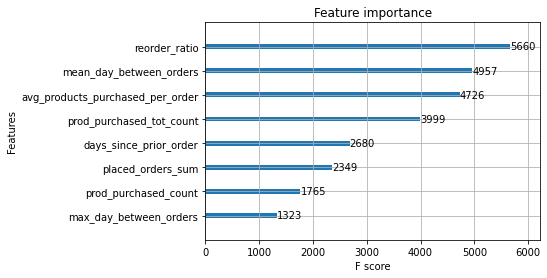

In [ ]:
xgb.plot_importance(model)

In [ ]:
X_te = xgb.DMatrix(X_test)

In [ ]:
X_test['reordered'] = model.predict(X_te)

In [ ]:
X_test.head()

,prod_purchased_count,placed_orders_sum,mean_day_between_orders,max_day_between_orders,prod_purchased_tot_count,reorder_ratio,avg_products_purchased_per_order,days_since_prior_order,reordered
6857932,2,22,12.142857,30.0,127,0.479339,5.772727,24.0,0.048067
5543187,1,9,24.250000,30.0,111,0.184466,12.333333,2.0,0.026054
13060830,1,67,5.378788,18.0,762,0.686508,11.373134,2.0,0.010651
5540739,1,6,24.800000,30.0,57,0.187500,9.500000,30.0,0.056219
4913900,1,5,13.500000,30.0,24,0.142857,4.800000,4.0,0.044042


### 5.2 Determine Threshold

In [ ]:
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

probs = X_test.reordered

In [ ]:
probs.head()

6857932     0.048067
5543187     0.026054
13060830    0.010651
5540739     0.056219
4913900     0.044042
Name: reordered, dtype: float32

In [ ]:
#thresholds range and steps
thresholds = arange(0, 1, 0.001)

#get scores from each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]

#get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.202, F-Score=0.38992


### 5.3 Test Threshold

In [ ]:
Threshold = 0.202

In [ ]:
X_test.loc[X_test['reordered'] > Threshold, 'reordered'] = 1

In [ ]:
X_test.loc[X_test['reordered'] <= Threshold, 'reordered'] = 0

In [ ]:
X_test.head()

,prod_purchased_count,placed_orders_sum,mean_day_between_orders,max_day_between_orders,prod_purchased_tot_count,reorder_ratio,avg_products_purchased_per_order,days_since_prior_order,reordered
6857932,2,22,12.142857,30.0,127,0.479339,5.772727,24.0,0.0
5543187,1,9,24.250000,30.0,111,0.184466,12.333333,2.0,0.0
13060830,1,67,5.378788,18.0,762,0.686508,11.373134,2.0,0.0
5540739,1,6,24.800000,30.0,57,0.187500,9.500000,30.0,0.0
4913900,1,5,13.500000,30.0,24,0.142857,4.800000,4.0,0.0


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, X_test.reordered))

              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93    229461
         1.0       0.35      0.43      0.39     24779

    accuracy                           0.87    254240
   macro avg       0.65      0.67      0.66    254240
weighted avg       0.88      0.87      0.87    254240



# Build Model_2 for real test set

In [32]:
import xgboost as xgb

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 9,
    'min_child_weight': 10,
    'gamma': 0.7,
    'subsample': 0.70,
    'colsample_bytree': 0.95,
    'alpha': 0.05,
    'lambda': 10
}

X_subtrain = xgb.DMatrix(subtrain.drop(['reordered'], axis=1), label=subtrain['reordered'])
#n_estimator best setting 190
model_2 = xgb.train(params, X_subtrain, num_boost_round=190)

### Feature Importance

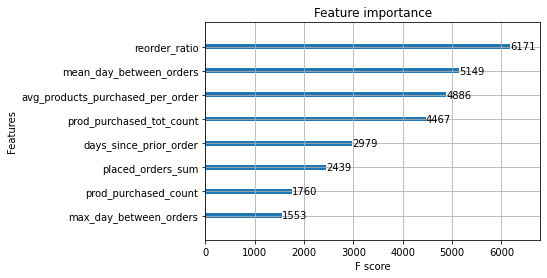

In [33]:
xgb.plot_importance(model_2)

### Apply model_2

In [34]:
test = each[each['eval_set']=='test']
test = test.drop(['eval_set', 'user_id', 'reordered'], axis=1)
test.head()

,product_id,prod_purchased_count,placed_orders_sum,mean_day_between_orders,max_day_between_orders,prod_purchased_tot_count,reorder_ratio,avg_products_purchased_per_order,order_id,days_since_prior_order
120,248,1,12,12.090909,21.0,88,0.705128,7.333333,2774568,11.0
121,1005,1,12,12.090909,21.0,88,0.705128,7.333333,2774568,11.0
122,1819,3,12,12.090909,21.0,88,0.705128,7.333333,2774568,11.0
123,7503,1,12,12.090909,21.0,88,0.705128,7.333333,2774568,11.0
124,8021,1,12,12.090909,21.0,88,0.705128,7.333333,2774568,11.0


In [36]:
# Apply model to the real test set

X_real_test = xgb.DMatrix(test.drop(['order_id', 'product_id'], axis=1))
test['reordered'] = model_2.predict(X_real_test)
Threshold = 0.202
test.loc[test['reordered'] > Threshold, 'reordered'] = 1

In [37]:
test.head()

,product_id,prod_purchased_count,placed_orders_sum,mean_day_between_orders,max_day_between_orders,prod_purchased_tot_count,reorder_ratio,avg_products_purchased_per_order,order_id,days_since_prior_order,reordered
120,248,1,12,12.090909,21.0,88,0.705128,7.333333,2774568,11.0,0.074182
121,1005,1,12,12.090909,21.0,88,0.705128,7.333333,2774568,11.0,0.074182
122,1819,3,12,12.090909,21.0,88,0.705128,7.333333,2774568,11.0,1.000000
123,7503,1,12,12.090909,21.0,88,0.705128,7.333333,2774568,11.0,0.074182
124,8021,1,12,12.090909,21.0,88,0.705128,7.333333,2774568,11.0,0.074182


In [39]:
#Create submission
kaggle_sub = test[test['reordered']==1]
kaggle_sub = kaggle_sub.groupby('order_id')['product_id'].agg(lambda l: ' '.join([str(i) for i in l]))
kaggle_sub = kaggle_sub.to_frame('products').reset_index()

In [40]:
#Replace missing orders with none -> order with no reordered item
no_orders = pd.DataFrame(set(test.order_id) - set(kaggle_sub.order_id), columns=['order_id'])
no_orders['products'] = 'None'
kaggle_sub = kaggle_sub.append(no_orders)
kaggle_sub = kaggle_sub.sort_values('order_id')
kaggle_sub.columns = ['order_id', 'products']

In [41]:
kaggle_sub.head()

,order_id,products
0,17,13107
1,34,39180 39475 43504 47029 47766 47792
2,137,23794 24852 38689 41787
3,182,5479 9337 13629 21903 24009 27104 33000 34243 ...
4,257,24852 27104 27966 29837 45013 49235


In [43]:
kaggle_sub.to_csv('/content/kaggle_sub.csv', index=False)